# Temporal Dominance of Sensations

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

df = pd.read_csv('Data_TDS.csv',delimiter=';')
df.head()

,Judge,Product,Attribute,Time
0,J1,P1,START,0
1,J1,P1,Woody,2
2,J1,P1,Salty,7
3,J1,P1,Sour,13
4,J1,P1,Acid,14


In [106]:
# I might have missed it, but from the chapter it is not clear to me if and how ratings are interpolated over individual trials.
# this is however necessary to  average the curves across participants!
# For now, I will interpolate at 0.5 sec, which seems conisstent with the processed data presented in the chapter

# make a function to compute the sensation dominance curves 
def compute_curve(df, t, resp, active_attribute):
    idxs = [resp.index(active_attribute)] if active_attribute in resp else [] # returns all indexes where the response is the currently evaluated attribute
    
    curve = np.zeros(t.shape)
    for idx in idxs:
        curve[(t >= df.Time[idx])  & (t <= df.Time[idx+1])] = 1
    
    t_i = np.arange(0,1,.01)
    f_norm_curve = interp1d(t/t[-1], curve, kind='linear')
    norm_curve = f_norm_curve(t_i)
    
    return [curve, norm_curve]


# now we can make a new dataframe with the curves for each product and judge
df_new = pd.DataFrame(columns = ['Judge','Product','Attribute','Curve','Normalized_curve'])

judges     = df.Judge.unique()
products   = df.Product.unique()
attributes = df.Attribute.unique()
attributes = np.delete(attributes, np.where((attributes == 'STOP') | (attributes == 'START')))

for judge in judges:
    for product in products:
        t_end = list(df.Time[(df.Judge == judge) & (df.Product == product)])[-1]
        resp = list(df.Attribute[(df.Judge == judge) & (df.Product == product)])
        t = np.arange(0,t_end, 0.5)
        
        for attribute in attributes:
            curve, norm_curve = compute_curve(df, t, resp, attribute)
            df1 = pd.DataFrame([[judge, product, attribute, curve, norm_curve]], columns = ['Judge','Product','Attribute','Curve','Normalized_curve'])
            df_new = df_new.append(df1) 
            


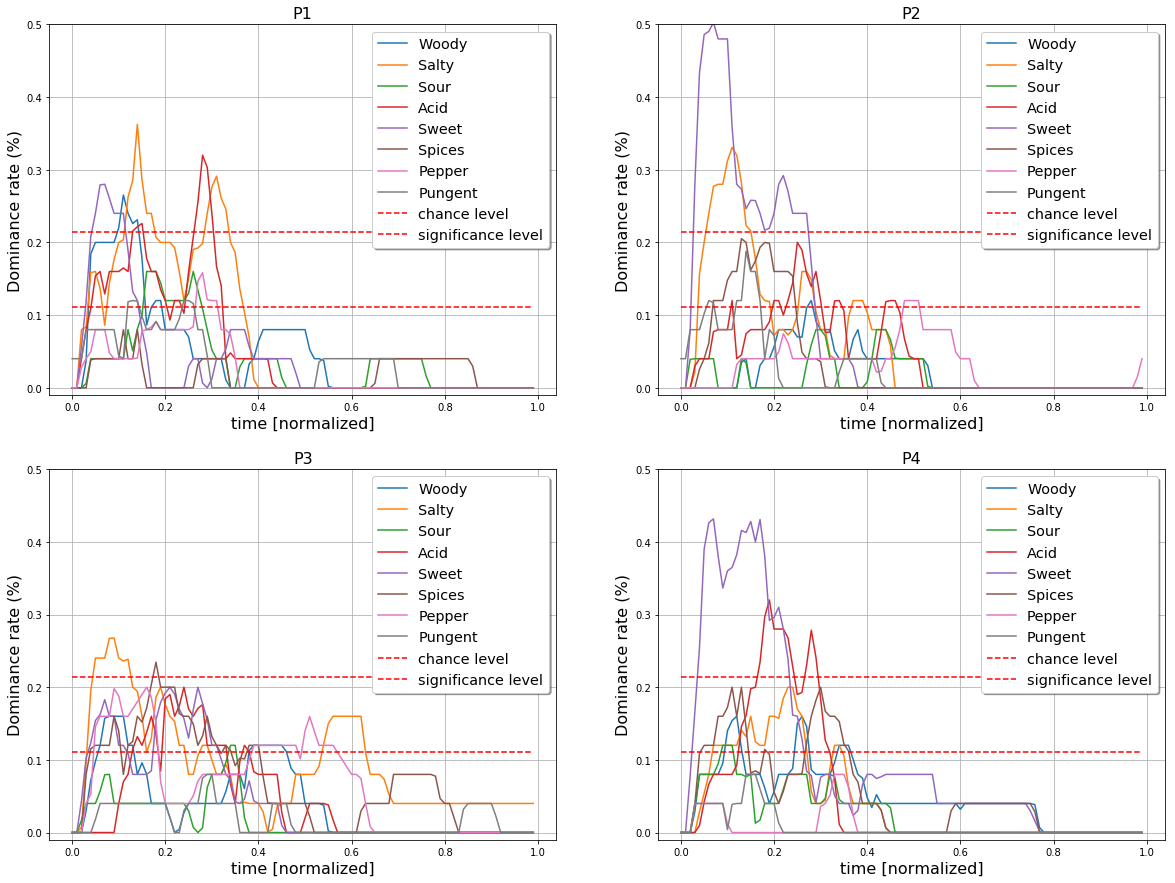

In [113]:
# now we can compute average curves for each product

df_average = pd.DataFrame(columns = ['Product','Attribute','Normalized_curve'])

N = len(judges) # number of judgements (judges * replications). in this case the design is balanced with 1 repetition. if this is not the case this has to be adjusted
P_0 = 1/(len(attributes) + 1)
P_s = P_0 + 1.645 * np.sqrt((P_0*(1-P_0))/N)
t = np.arange(0,1,.01)


fig, axes = plt.subplots(2,2, figsize = (20,15))
for product, ax in zip(products, axes.ravel()):
    for attribute in attributes:
        curve = np.array(list(df_new.Normalized_curve[(df_new.Product == product) & (df_new.Attribute == attribute)])).sum(axis=0) / N
        df1 = pd.DataFrame([[product, attribute, curve]], columns = ['Product','Attribute','Normalized_curve'])
        df_average = df_average.append(df1)
        
        ax.plot(t, curve, label = attribute)
    ax.plot([t[0], t[-1]], [P_0, P_0], '--k', label = 'chance level')
    ax.plot([t[0], t[-1]], [P_s, P_s], '--r', label = 'significance level')
    
    ax.set_xlabel('time [normalized]', fontsize  = 16)
    ax.set_ylabel('Dominance rate (%)', fontsize  = 16)
    ax.set_title(product,  fontsize  = 16); 
    ax.set_ylim(-.01, .5)
    ax.grid()
    ax.legend(loc='upper right', shadow=True, fontsize='x-large')
plt.show()
        
    
    
